# <center> Dota 2 winner prediction

<img src='https://habrastorage.org/webt/ua/vn/pq/uavnpqfoih4zwwznvxubu33ispy.jpeg'>

#### <center> Originally done by Peter Romov, translated and adapted by Yury Kashnitskiy (@yorko)
    
### Quick start

Grab features prepared by organizers, train a model and submit. 

1. [Data description](#Data-description)
2. [Features created by organizers](#Features-created-by-organizers)
3. [Training and evaluating a model](#Training-and-evaluating-a-model)
4. [Preparing a submission](#Preparing-a-submission)

### Now do it as a real Data Scientist

5. [Cross-validation](#Cross-validation)
6. [Working with all available information on Dota games](#Working-with-all-available-information-on-Dota-games)
7. [Feature engineering](#Feature-engineering)
8. [How to build initial features from scratch](#How-to-build-initial-features-from-scratch)

## Data description

We have the following files:

- `sample_submission.csv`: example of a submission file
- `train_matches.jsonl`, `test_matches.jsonl`: full "raw" training data 
- `train_features.csv`, `test_features.csv`: features created by organizers
- `train_targets.csv`: results of training games (including the winner)

## How to build initial features from scratch

Now we diclose the code that we used to build initial features `train_features.csv` and `test_features.csv`. You can modify the following code to add more features.

In a nutshell:

1. the  `extract_features_csv(match)` function extracts features from game descriptions and writes them into a dictionary
2. the `extract_targets_csv(match, targets)` function extracts the target variable `radiant_win`
3. iterating through the file with raw data, we collect all features
4. with `pandas.DataFrame.from_records()` we create dataframes with new features

In [107]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
    
    #added by me
    'nearby_creep_death_count',
]

#added by me
PLAYER_COUNT_FIELDS = ['purchase', 'hero_inventory', 'damage', 'damage_taken', 'ability_upgrades',\
                       'killed', 'killed_by', 'hero_hits', 'damage_inflictor_received' ]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
            
        for new_field in PLAYER_COUNT_FIELDS:
            column_name = '%s_%s' % (player_name, new_field)
            row.append((column_name, len(player[new_field])))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

#### Function to read files with game descriptions

The following function `read_matches(filename)`, can be used to read raw data on Dota 2 games.

We recommend to install two Python packages: `ujson` and `tqdm`, it'll make the execution faster and 

In [108]:
import os

try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Please install ujson to read JSON oblects faster')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Please install tqdm to track progress with Python loops')

def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

Please install ujson to read JSON oblects faster


In [110]:
%%time

df_new_features = []
df_new_targets = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    df_new_features.append(features)
    df_new_targets.append(targets)
    
df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
df_new_targets = pd.DataFrame.from_records(df_new_targets).set_index('match_id_hash')

df_new_features.to_csv(os.path.join(PATH_TO_DATA, 'train_features.csv'))
df_new_targets.to_csv(os.path.join(PATH_TO_DATA, 'train_targets.csv'))

df_new_features = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'test_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    
    df_new_features.append(features)
    
df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
df_new_features.to_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'))


Wall time: 2min 43s


## Features created by organizers

These are basic features which include simple players' statistics. Scroll to the end to see how to build these features from raw json files.

In [111]:
import os
import pandas as pd

PATH_TO_DATA = 'data/dota/'

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train_features.csv'), 
                                    index_col='match_id_hash')
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), index_col='match_id_hash')


We have ~ 40k games, each described by `match_id_hash` (game id) and 245 features. Also `game_time` is given - time (in secs) when the game was over. 

In [112]:
df_train_features.shape

(39675, 345)

In [113]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_nearby_creep_death_count,d5_purchase,d5_hero_inventory,d5_damage,d5_damage_taken,d5_ability_upgrades,d5_killed,d5_killed_by,d5_hero_hits,d5_damage_inflictor_received
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,17,6,4,5,2,0,2,0,2,4
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,27,12,0,4,3,4,3,1,2,3
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,4,3,0,0,0,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,75,8,6,10,7,3,2,1,2,4
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,65,7,4,17,16,2,10,1,1,4


We are interested in the `radiant_win` column in `train_targets.csv`. All these features are not known during the game (they come "from future" as compared to `game_time`), so we have these features only for training data. 

In [114]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


In [115]:
df_train_features.shape, df_train_targets.shape

((39675, 345), (39675, 5))

In [116]:
df_train_features.describe()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_nearby_creep_death_count,d5_purchase,d5_hero_inventory,d5_damage,d5_damage_taken,d5_ability_upgrades,d5_killed,d5_killed_by,d5_hero_hits,d5_damage_inflictor_received
count,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,...,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000
mean,1146.082798,19.584776,4.772350,6.524865,7.338500,51.103138,3.147876,3.268809,4.670170,6.289628,...,148.622004,16.672539,4.995640,18.147347,13.935753,8.140693,12.576282,1.972804,3.286326,8.357177
std,767.206621,6.304976,3.260582,6.492107,13.366381,34.603057,3.724282,3.283323,5.225349,8.203957,...,123.890536,8.403120,1.165927,12.695755,10.078076,6.053742,11.243161,1.599371,1.498982,4.743827
min,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,521.000000,22.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,...,56.000000,10.000000,4.000000,8.000000,6.000000,3.000000,4.000000,1.000000,2.000000,4.000000
50%,1044.000000,22.000000,7.000000,4.000000,3.000000,44.000000,2.000000,2.000000,3.000000,3.000000,...,119.000000,16.000000,5.000000,15.000000,11.000000,7.000000,8.000000,2.000000,3.000000,8.000000
75%,1656.000000,22.000000,7.000000,10.000000,9.000000,81.000000,5.000000,5.000000,7.000000,9.000000,...,210.000000,22.000000,6.000000,26.000000,19.000000,13.000000,18.000000,3.000000,4.000000,12.000000
max,4933.000000,23.000000,7.000000,43.000000,291.000000,120.000000,32.000000,27.000000,40.000000,84.000000,...,1964.000000,62.000000,6.000000,69.000000,54.000000,25.000000,60.000000,9.000000,12.000000,29.000000


## Working with all available information on Dota games
Raw data descriptions for all games are given in files `train_matches.jsonl` and `test_matches.jsonl`. Each file has one entry for each game in [JSON](https://en.wikipedia.org/wiki/JSON) format. You only need to know that it can be easily converted to Python objects via the `json.loads` method.

##### Let's explore a single entry

In [121]:
import json

with open(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')) as fin:
    # read the 18-th line
    for i in range(15):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

The `match` object is now a big Python dictionary. In `match['players']` we have a description of each player.

You might think that this `match` object look ugly. You're right! That's actually the real data. And it's the ability to extract nice features from raw data that makes good Data Scientists stand out. You might even be unfamiliar with Dota (or any other application domain) but still be able to construct a good model via feature engineering. It's art and craftmanship at the same time.   

In [122]:
match

{'game_time': 721,
 'match_id_hash': 'ab3cc6ccac661a1385e73a2e9f21313a',
 'teamfights': [{'start': 564.747,
   'end': 601.242,
   'last_death': 586.145,
   'deaths': 3,
   'players': [{'deaths_pos': {},
     'ability_uses': {'witch_doctor_paralyzing_cask': 1,
      'witch_doctor_maledict': 1},
     'item_uses': {'magic_stick': 1},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 567,
     'healing': 150,
     'gold_delta': 198,
     'xp_delta': 295},
    {'deaths_pos': {},
     'ability_uses': {'troll_warlord_berserkers_rage': 4,
      'troll_warlord_whirling_axes_ranged': 1,
      'troll_warlord_whirling_axes_melee': 1},
     'item_uses': {},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 305,
     'healing': 51,
     'gold_delta': 83,
     'xp_delta': 181},
    {'deaths_pos': {},
     'ability_uses': {'tinker_march_of_the_machines': 1},
     'item_uses': {},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 0,
    

#### Player description

In [123]:
player = match['players'][9]

In [124]:
player

{'player_slot': 132,
 'hero_id': 54,
 'hero_name': 'npc_dota_hero_life_stealer',
 'account_id_hash': 'd685e2f9a2e77cd50477003a6f431dfa',
 'ability_upgrades': [{'ability': 5250, 'time': 208, 'level': 1},
  {'ability': 5249, 'time': 304, 'level': 2},
  {'ability': 5251, 'time': 334, 'level': 3},
  {'ability': 5250, 'time': 375, 'level': 4},
  {'ability': 5250, 'time': 535, 'level': 5},
  {'ability': 5250, 'time': 704, 'level': 6},
  {'ability': 5249, 'time': 708, 'level': 7}],
 'obs_placed': 0,
 'sen_placed': 0,
 'creeps_stacked': 0,
 'camps_stacked': 0,
 'rune_pickups': 1,
 'firstblood_claimed': 0,
 'teamfight_participation': 0.125,
 'towers_killed': 0,
 'roshans_killed': 0,
 'observers_placed': 0,
 'stuns': 0,
 'max_hero_hit': {'type': 'max_hero_hit',
  'time': 436.649,
  'max': True,
  'inflictor': None,
  'unit': 'npc_dota_hero_life_stealer',
  'key': 'npc_dota_hero_legion_commander',
  'value': 109,
  'slot': 9,
  'player_slot': 132},
 'times': [0, 60, 120, 180, 240, 300, 360, 420, 

In [125]:
len(match['teamfights'])

1

KDA: the number of kills, deaths, and assists to alleys.

In [126]:
player['kills'], player['deaths'], player['assists'], len(player['killed']), len(player['hero_inventory'])

(0, 2, 1, 5, 6)

Some statistics on player abilities:

In [127]:
player['ability_uses']

{'life_stealer_open_wounds': 3, 'life_stealer_rage': 4}

In [128]:
len(player['ability_upgrades'])

7

#### Example: time series for each player's gold.

In [129]:
%matplotlib inline
from matplotlib import pyplot as plt

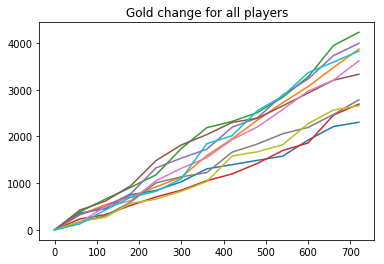

In [130]:
for player in match['players']:
    plt.plot(player['times'], player['gold_t'])
    
plt.title('Gold change for all players');

#### Reading data in a loop

Reading data on all games might take some 2-3 minutes. Thus you'd better stick to the following approach:

1. Read a small amount (10-100) of games
2. Write code to extract features from these JSON objects
3. Make sure the code works fine
4. Run the code with all available data
5. Save results to a `pickle` file so that you don't need to run all computations from scratch next time 

In [131]:
for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    game_time = match['game_time']
    
    # processing each game
    
    for player in match['players']:
        pass  # processing each player

## Feature engineering

In [132]:
def add_new_features(df_features, matches_file):
    
    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Counting ruined towers for both teams
        radiant_tower_kills = 0
        dire_tower_kills = 0
        radiant_roshan_kills = 0
        dire_roshan_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1
            elif objective['type'] == 'CHAT_MESSAGE_ROSHAN_KILL':
                if objective['team'] == 2:
                    radiant_roshan_kills += 1
                if objective['team'] == 3:
                    dire_roshan_kills += 1        
                    
                    

        # Write new features
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills
        df_features.loc[match_id_hash, 'radiant_roshan_kills'] = radiant_roshan_kills
        df_features.loc[match_id_hash, 'dire_roshan_kills'] = dire_roshan_kills
        
        # ... here you can add more features ...
        df_features.loc[match_id_hash, 'teamfight_count'] = len(match['teamfights'])

In [133]:
# copy the dataframe with features
#df_train_features_extended = df_train.copy()
df_train_features_extended = df_train_features.copy()

# add new features
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              'train_matches.jsonl'))

In [134]:
%%time
# Build the same features for the test set
#df_test_features_extended = df_test.copy()
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))


Wall time: 42.2 s


We see new features added to the right.

In [327]:
df_train_features_extended.shape

(39675, 351)

In [454]:
X_train_math = df_train_features[['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len']].copy()

mean_cols = ['kills','deaths', 'assists','denies','gold', 'lh','xp','health','max_health','max_mana', 'level', 'stuns',\
             'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed','teamfight_participation',\
             'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed', 'nearby_creep_death_count', 'purchase', \
             'hero_inventory', 'damage', 'damage_taken', 'ability_upgrades',\
                      'killed', 'killed_by', 'hero_hits', 'damage_inflictor_received', 'x','y']

for col in tqdm_notebook(mean_cols):
    for let in ['r','d']:
        full_cols = [x+col for x in [let +'%s_' %i for i in range(1, 6)]]
        X_train_math[let+col+'_mean'] = df_train_features_extended[full_cols].apply(np.mean, axis=1)
        X_train_math[let+col+'_std'] = df_train_features_extended[full_cols].apply(np.std, axis=1)
        #X_train[let+col+'_min'] = df_train_features_extended[full_cols].apply(np.min, axis=1)
        #X_train_math[let+col+'_sum'] = df_train_features_extended[full_cols].apply(np.sum, axis=1)
        #X_train[col+'_mean_ratio'] = X_train['r'+col+'_mean']/X_train['d'+col+'_mean']
        
X_test_math = df_test_features[['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len']].copy()

for col in tqdm_notebook(mean_cols):
    for let in ['r','d']:
        full_cols = [x+col for x in [let +'%s_' %i for i in range(1, 6)]]
        X_test_math[let+col+'_mean'] = df_test_features_extended[full_cols].apply(np.mean, axis=1)
        X_test_math[let+col+'_std'] = df_test_features_extended[full_cols].apply(np.std, axis=1)
        #X_test[let+col+'_min'] = df_test_features_extended[full_cols].apply(np.min, axis=1)
        #X_test_math[let+col+'_sum'] = df_test_features_extended[full_cols].apply(np.sum, axis=1)
        

In [346]:
X_train.shape

(39675, 191)

#### Evaluating new features

Let's run cross-validation with a fixed model but with two different datasets:

1. with features built by organizers (base)
2. with new features that we've added (extended)

## Training and evaluating a model

#### Let's construct a feature matrix `X` and a target vector `y`

In [402]:
# let us make the extended features sets as our train and test sets
from sklearn.preprocessing import StandardScaler

X_train = df_train_features_extended.values
y_train = df_train_targets['radiant_win'].values

X_test = df_test_features_extended.values

In [403]:
cols = ['radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills','teamfight_count', \
                                    'radiant_roshan_kills', 'dire_roshan_kills']


In [455]:
X_train_math.shape, X_test_math.shape

((39675, 137), (10000, 137))

In [456]:
X_train_math.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'rkills_mean', 'rkills_std', 'dkills_mean', 'dkills_std',
       'rdeaths_mean',
       ...
       'ddamage_inflictor_received_mean', 'ddamage_inflictor_received_std',
       'rx_mean', 'rx_std', 'dx_mean', 'dx_std', 'ry_mean', 'ry_std',
       'dy_mean', 'dy_std'],
      dtype='object', length=137)

In [457]:
X_train = df_train_features_extended[cols]
X_train = X_train.join(X_train_math)

X_test = df_test_features_extended[cols]
X_test = X_test.join(X_test_math)

#### Perform  a train/test split (a simple validation scheme)

In [458]:
X_train.shape, X_test.shape

((39675, 143), (10000, 143))

## Cross-validation

As we already know, cross-validation is a more reliable validation technique than just one train/test split. Here we'll resort to `ShuffleSplit` to create 5 70%/30% splits. 

In [459]:
from sklearn.model_selection import ShuffleSplit, KFold, StratifiedKFold
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=17)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [460]:
from sklearn.model_selection import cross_val_score

#### New submission

In [461]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, solver='liblinear', class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-15, 15, 31)}

In [462]:
import warnings
warnings.filterwarnings("ignore")

In [463]:
pipeline_cv = GridSearchCV(estimator=logit_pipe, param_grid=logit_pipe_params, scoring='roc_auc', cv=cv, verbose=1)
cv_score = cross_val_score(estimator=pipeline_cv, X= X_train, y=y, cv=cv, scoring='roc_auc')

#cv_score = cross_val_score(estimator=pipeline_cv, X= df_train_features_extended.values, y=y, cv=cv, scoring='roc_auc')
cv_score.mean()

Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed: 11.3min finished


Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed: 10.8min finished


Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed: 11.9min finished


Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:  8.7min finished


Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:  9.9min finished


0.8202597684552728

In [464]:
X_train.shape, X_test.shape

((39675, 143), (10000, 143))

In [465]:
pipeline_cv.fit(X_train, y)

Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed: 12.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logit__C': array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08,
       1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [466]:
lr_submission_extended = pd.DataFrame(
    {'radiant_win_prob': pipeline_cv.predict_proba(X_test)[:, 1]}, 
    index=df_test_features.index,
)
lr_submission_extended.to_csv('submission_143_lr_1515.csv')

## LR scores:

cv = 0.8202597684552728, LB = 0.83172 (143 features, mean + std, C: -15, 15, 31)

cv = 0.8170662355544248, LB = 0.83294 (77 features mean, C:-15,15,31) **BEST SCORE**

cv = 0.8170662355544248 (77 features C:-8,8, 17)

cv = 0.8169305623661105, (77 features)

cv = 0.8134799871856432, LB = 0.82733 (351 features)

cv = 0.819602217057661, LR = 0.83057 (197 features)

cv = 0.8196042723563256, LR = 0.83054 (extended features - 129 + 6)

cv = 0.818236457187913, LR = 0.83151 (mean and std of features - 129 features)

cv = 0.8161957013785699, LB = 0.82808 (113 features)

cv = 0.8172367834549521, LB  = 0.82916 (137 features)

cv = 0.8248366516306609 (mistake, need to drop the int hero ids from x-train before merging, repeat tomorrow -WRONG hero ids were never there when averaging), LB = 0.82814

cv = 0.8168867265744826, LB = 0.82902 (137 features)

cv = 0.8185628650893468, LB = 0.83212 (179 features)

cv = 0.8182369666489772, LB = 0.83206 (averaging features for players - 191 features total) 

cv = 0.8134799871856432, LB = 0.82733 (all new features)

cv= 0.8137461593524739
leaderboard = 0.82587

cv 0.8134623439755726, LB 0.82490

In [146]:
*************

SyntaxError: invalid syntax (<ipython-input-146-07f3fcc11938>, line 1)

In [444]:
from sklearn.model_selection import train_test_split

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                      test_size=0.3, 
                                                      random_state=17)

In [419]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(random_state=17, n_estimators=1000, colsample_bytree=0.66,
                       max_depth=-1, num_leaves=5, reg_alpha=1.2, subsample=0.75,
                       reg_lambda=1, learning_rate=0.5)
lgbm.fit(X_train_part, y_train_part)
lgbm_valid_pred = lgbm.predict_proba(X_valid)[:, 1]

print(roc_auc_score(y_valid, lgbm_valid_pred))

0.7836276649353376


In [420]:
parameters = {'num_leaves': [7, 15, 31, 63, 127, 255],
              'max_depth': [3, 4, 5, 6]}
grid_search = GridSearchCV(estimator=lgbm, param_grid=parameters, 
                           verbose=1, scoring='roc_auc',
                           n_jobs=4, cv=5)
grid_search = grid_search.fit(X_train_part, y_train_part)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed: 16.9min finished


In [421]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 6, 'num_leaves': 31}, 0.7901117804299679)

In [422]:
grid_search.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
        importance_type='split', learning_rate=0.5, max_depth=6,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=17, reg_alpha=1.2, reg_lambda=1, silent=True,
        subsample=0.75, subsample_for_bin=200000, subsample_freq=0)

In [445]:
lgbm2 = LGBMClassifier(random_state=17, n_estimators=1000, colsample_bytree=0.66,
                       max_depth=6, num_leaves=31, reg_alpha=1.2, subsample=0.75,
                       reg_lambda=1, learning_rate=0.5)
lgbm2.fit(X_train_part, y_train_part)
lgbm_valid_pred = lgbm2.predict_proba(X_valid)[:, 1]

print(roc_auc_score(y_valid, lgbm_valid_pred))

0.7835501668091286


In [425]:
lgbm2.fit(X_train, y_train)

lgbm_submission_extended = pd.DataFrame(
    {'radiant_win_prob': lgbm2.predict_proba(X_test)[:, 1]}, 
    index=df_test_features.index,   
)
lgbm_submission_extended.to_csv('submission_lgbm_77.csv')

cv = 0.7835501668091286 (77 features)

cv = 0.7895580116906447, LB = 0.80703 (351 features)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

In [446]:
#X_train = df_new
y_train = y
#X_test = df_test_new
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.2, random_state=17)

In [447]:
xgb2 = XGBClassifier(seed=17,max_depth=6, num_leaves=3, n_estimators=500)
xgb2.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb2.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

0.8082199717913415

In [325]:
xgb2.fit(X_train.values, y)
#xgb2.fit(df_train_features_extended.values, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, num_leaves=3, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=17, silent=True, subsample=1)

In [326]:
xgb_submission_extended = pd.DataFrame(
    {'radiant_win_prob': xgb2.predict_proba(X_test.values)[:, 1]}, 
    index=df_test_features.index,
    #{'radiant_win_prob': xgb2.predict_proba(df_test_features_extended.values)[:, 1]}, 
    #index=df_test_features_extended.index,    
)
xgb_submission_extended.to_csv('submission_meanstd_xgb.csv')

roc auc = 0.8082199717913415 (77 features)

roc auc = 0.8144215112275909, LB = 0.82102

roc_auc = 0.8074697963463142, score = 0.81605

**We will take XGB's feature importances (those features) and apply them to LR pipeline which has given us the best results so far**

In [ ]:
feature_importance.head()

In [ ]:
cols = []
for f in feature_importance['feature']:
    cols.append(f)

In [ ]:
len(cols)

In [ ]:
new_train = df_train_features_extended[cols[:150]]

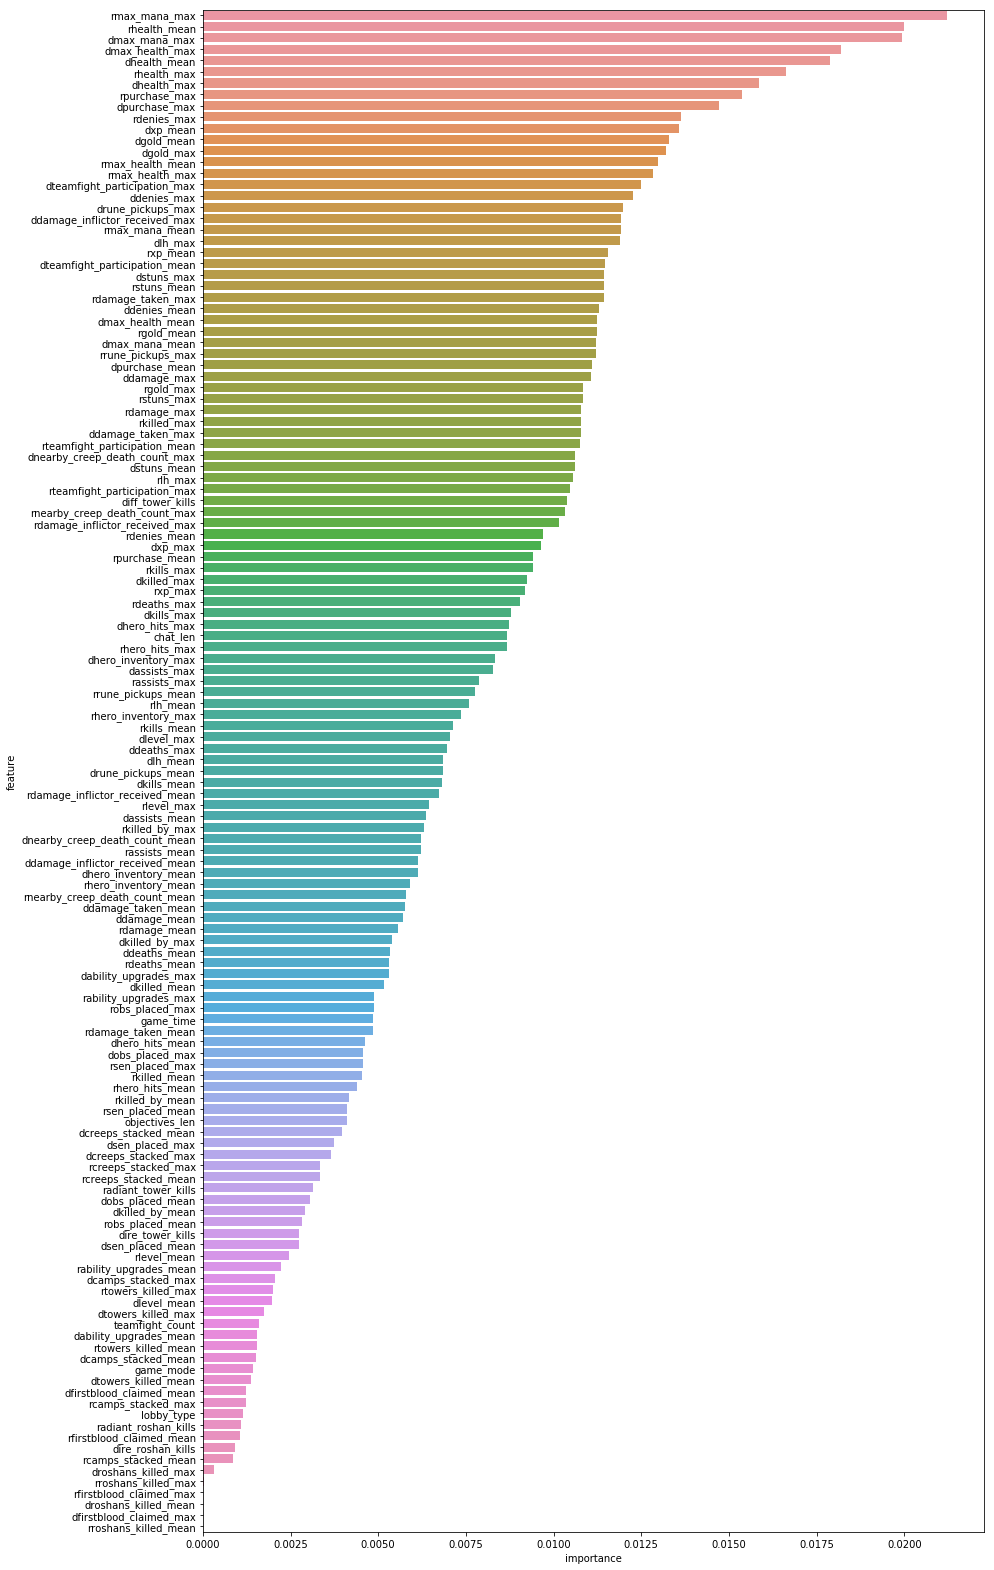

In [343]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':xgb2.feature_importances_}).\
sort_values('importance', ascending=False)[:150]

plt.figure(figsize=(14,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature);

In [ ]:
new_train.head()

In [ ]:
new_test = df_test_features_extended[cols[:150]]

In [ ]:
new_test.shape

In [ ]:
pipeline_cv = GridSearchCV(estimator=logit_pipe, param_grid=logit_pipe_params, scoring='roc_auc', cv=cv, verbose=1)

cv_score = cross_val_score(estimator=pipeline_cv, X= new_train.values, y=y, cv=cv, scoring='roc_auc')
cv_score.mean()

In [ ]:
pipeline_cv.fit(new_train.values, y)
lr_submission_extended = pd.DataFrame(
    {'radiant_win_prob': pipeline_cv.predict_proba(new_test.values)[:, 1]}, 
    index=df_test_features.index,
)
lr_submission_extended.to_csv('submission_extended_150feat_lr.csv')

## Values obtained using feature importances from xgb2

LR 150 features: roc auc = 0.8144512168323829, score = 0.82647

LR 125 features: roc auc = 0.8140515603787852, score =  0.82593

**LR 100 features: roc auc = 0.8128571857424987, score = 0.82671** BEST SCORE

LR 50 features: roc auc= 0.7927630785737716, score = 0.799

## Let us try to find the top features for logit and apply those on the pipeline

In [ ]:
logit.fit(df_train_features_extended, y)

In [ ]:
coefs=logit.coef_[0]
top_feats = np.argpartition(coefs, -289)[-289:]
top_feats_sorted=top_feats[np.argsort(-coefs[top_feats])]
print(top_feats_sorted)

In [ ]:
cols = []

for i in top_feats_sorted:
    cols.append(df_train_features_extended.columns[i])

In [ ]:
new_train = df_train_features_extended[cols]
new_test = df_test_features_extended[cols]

In [ ]:
pipeline_cv = GridSearchCV(estimator=logit_pipe, param_grid=logit_pipe_params, scoring='roc_auc', cv=cv, verbose=1)

cv_score = cross_val_score(estimator=pipeline_cv, X= new_train.values, y=y, cv=cv, scoring='roc_auc')
cv_score.mean()

In [ ]:
pipeline_cv.fit(new_train.values, y)
lr_submission_extended = pd.DataFrame(
    {'radiant_win_prob': pipeline_cv.predict_proba(new_test.values)[:, 1]}, 
    index=df_test_features.index,
)
lr_submission_extended.to_csv('submission_real_200feat_lr.csv')

all 280 features roc auc = 0.8134622420881881

200 top logit features roc auc = 0.8121597868157234, LB = 0.82339

150 top logit features roc auc = 0.803385033415499

100 top logit features roc auc = 0.7853918537901649

In [ ]:
df_train_features_extended.shape

In [166]:
from sklearn.decomposition import PCA
X_std = StandardScaler().fit_transform(X=X_train)

#pca = PCA(n_components=77, svd_solver='randomized', random_state=1)
pca = PCA()
pca.fit(X_std)

for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))


1 component: 58.49% of initial variance
2 component: 2.79% of initial variance
3 component: 2.54% of initial variance
4 component: 1.96% of initial variance
5 component: 1.78% of initial variance
6 component: 1.56% of initial variance
7 component: 1.28% of initial variance
8 component: 1.14% of initial variance
9 component: 1.02% of initial variance
10 component: 1.01% of initial variance
11 component: 0.97% of initial variance
12 component: 0.96% of initial variance
13 component: 0.86% of initial variance
14 component: 0.75% of initial variance
15 component: 0.73% of initial variance
16 component: 0.66% of initial variance
17 component: 0.64% of initial variance
18 component: 0.63% of initial variance
19 component: 0.61% of initial variance
20 component: 0.57% of initial variance
21 component: 0.56% of initial variance
22 component: 0.55% of initial variance
23 component: 0.54% of initial variance
24 component: 0.54% of initial variance
25 component: 0.53% of initial variance
26 compo

In [172]:
pca = PCA(n_components=150, svd_solver='randomized', random_state=1)
X_std_PCA = pca.fit_transform(X_std)

In [169]:
X_std_PCA.shape

(39675, 100)

In [171]:
X_train.shape

(39675, 191)

In [173]:
pipeline_cv = GridSearchCV(estimator=logit_pipe, param_grid=logit_pipe_params, scoring='roc_auc', cv=cv, verbose=1)

cv_score = cross_val_score(estimator=pipeline_cv, X= X_std_PCA, y=y, cv=cv, scoring='roc_auc')
cv_score.mean()

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   42.5s finished


Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   45.6s finished


Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   42.5s finished


Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   41.8s finished


Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   41.8s finished


0.8121780597098786

12 components -> 0.7909023637709727
25 -> 0.791113657392079
50 -> 0.7972503924283227
100 -> 0.8012366905705592, 0.8046036828586114 (averaging)
150 -> 0.8040615732202314,0.8121780597098786 (averaging)
250 -> 0.8096225512868707

In [175]:
pipeline_cv.fit(X_std_PCA, y)

X_test_PCA = pca.fit_transform(X_test)

lr_submission_extended = pd.DataFrame(
    {'radiant_win_prob': pipeline_cv.predict_proba(X_test_PCA)[:, 1]}, 
    index=df_test_features.index,
)
lr_submission_extended.to_csv('submission_150pca_lr.csv')

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   57.1s finished


In [371]:
p1 = pd.read_csv('submission_179feats_lr.csv')
p2 = pd.read_csv('submission_meanstd_lr.csv')

In [372]:
p1.head()

,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.511629
1,70e5ba30f367cea48793b9003fab9d38,0.972632
2,4d9ef74d3a2025d79e9423105fd73d41,0.970588
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.687975
4,bec17f099b01d67edc82dfb5ce735a43,0.234667


In [373]:
p3 = p1.copy()
p3['radiant_win_prob'] = 0.6*p1['radiant_win_prob'] + 0.4*p2['radiant_win_prob']

In [374]:
p3.head()

,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.507884
1,70e5ba30f367cea48793b9003fab9d38,0.970892
2,4d9ef74d3a2025d79e9423105fd73d41,0.971825
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.701119
4,bec17f099b01d67edc82dfb5ce735a43,0.262293


In [381]:
p3.index=p3['match_id_hash']
p3 = p3.drop(columns='match_id_hash')

In [382]:
p3.to_csv('p3_179feats_meanstd_lr.csv')

In [376]:
**********

SyntaxError: invalid syntax (<ipython-input-376-f2797ced5e5c>, line 1)

In [ ]:
xgb = XGBClassifier(seed=17) 
parameters = {'num_leaves': [3, 7, 15, 31, 63, 127], 'max_depth': [3, 4, 5, 6, 7]} 
grid_search = GridSearchCV(estimator=xgb, param_grid=parameters, verbose=1, scoring='roc_auc', n_jobs=4, cv=cv) 
grid_search = grid_search.fit(X_train, y_train)

grid_search.best_params_, grid_search.best_score_

## Go on!

- Discuss new ideas in Slack 
- Create new features
- Try new models and ensembles
- Submit predictions
- Go and win!

df_cat = pd.DataFrame()
hero_ids = ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', \
        'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']

for id in hero_ids:
    df_cat[id] = df_train_features[id].astype(str)


df_cat = pd.get_dummies(df_cat)

df_new = X_train.join(df_cat)

#repeat for the test set
for id in hero_ids:
    df_cat[id] = df_test_features[id].astype(str)

df_cat = pd.get_dummies(df_cat)
df_test_new = X_test.join(df_cat)